EDA - Exploratory Data Analysis

EDA датасета WiDS Datathon 2020. Структура:

1. Подключение библиотек, настройка путей и загрузка данных.
2. Обзор данных: метрики, проверка баланса классов, распределения таргета.
3. Анализ признаков: типизация, распределения, выявление аномалий, оценка feature importance и т.д.
4. Генерация визуализаций
5. Идеи для feature engineering

In [1]:
from __future__ import annotations

import warnings
from pathlib import Path

try:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
except ImportError as exc:  # pragma: no cover - executed only при некорректном окружении
    missing_pkg = str(exc).split("'")[1]
    raise ImportError(
        f"Не удалось импортировать {missing_pkg}. Убедитесь, что активировано окружение с зависимостями "
        " или выполните `pip install -r requirements.txt`."
    ) from exc

sns.set_theme(style="whitegrid", palette="crest")
warnings.filterwarnings("ignore")

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "raw"
FIGURES_DIR = PROJECT_ROOT / "models" / "eda_figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

TARGET_COL = "hospital_death"
ID_COLUMNS = ["encounter_id", "patient_id"]

print(f"Project root: {PROJECT_ROOT}")
print(f"Data dir: {DATA_DIR}")


Project root: D:\cursor projects\automl2025
Data dir: D:\cursor projects\automl2025\data\raw


In [2]:
def load_dataframe(path: Path) -> pd.DataFrame:
    """Загружает CSV файл и выводит базовую информацию."""
    if not path.exists():
        raise FileNotFoundError(
            f"Файл {path} не найден."
            
        )
    df = pd.read_csv(path)
    print(f"Loaded {path.name}: shape={df.shape}")
    return df


TRAIN_PATH = DATA_DIR / "training_v2.csv"
TEST_PATH = DATA_DIR / "unlabeled.csv"

train_df = load_dataframe(TRAIN_PATH)
test_df = load_dataframe(TEST_PATH)
train_df.head()


Loaded training_v2.csv: shape=(91713, 186)
Loaded unlabeled.csv: shape=(39308, 186)


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


# 1. Общий обзор данных

Ниже проверяем размеры выборки, типы столбцов и базовую статистику.


In [3]:
summary = pd.DataFrame({
    "dataset": ["train", "test"],
    "rows": [len(train_df), len(test_df)],
    "cols": [train_df.shape[1], test_df.shape[1]],
})
summary


,dataset,rows,cols
0,train,91713,186
1,test,39308,186


In [4]:
dtype_counts = train_df.dtypes.value_counts().rename_axis("dtype").reset_index(name="count")
dtype_counts


,dtype,count
0,float64,170
1,int64,8
2,object,8


## 2. Анализ целевой переменной

Таргет `hospital_death` является бинарной меткой (1 — пациент умер). Проверим баланс классов и динамику во времени.


In [5]:
target_stats = (
    train_df[TARGET_COL]
    .value_counts(dropna=False)
    .rename_axis("hospital_death")
    .reset_index(name="count")
)
target_stats["share"] = target_stats["count"] / len(train_df)
target_stats


,hospital_death,count,share
0,0,83798,0.913698
1,1,7915,0.086302


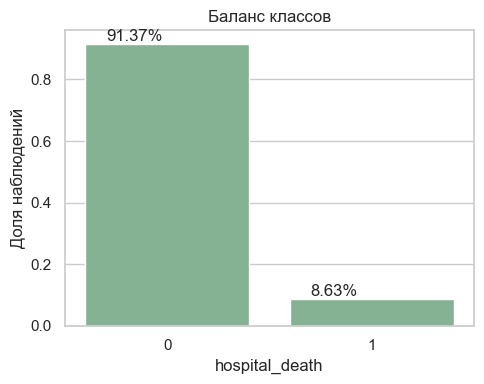

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(data=target_stats, x="hospital_death", y="share", ax=ax)
ax.set_ylabel("Доля наблюдений")
ax.set_xlabel("hospital_death")
ax.set_title("Баланс классов")
for p, share in zip(ax.patches, target_stats["share"]):
    ax.annotate(f"{share:.2%}", (p.get_x() + 0.1, p.get_height() + 0.01))
plt.tight_layout()
plt.show()


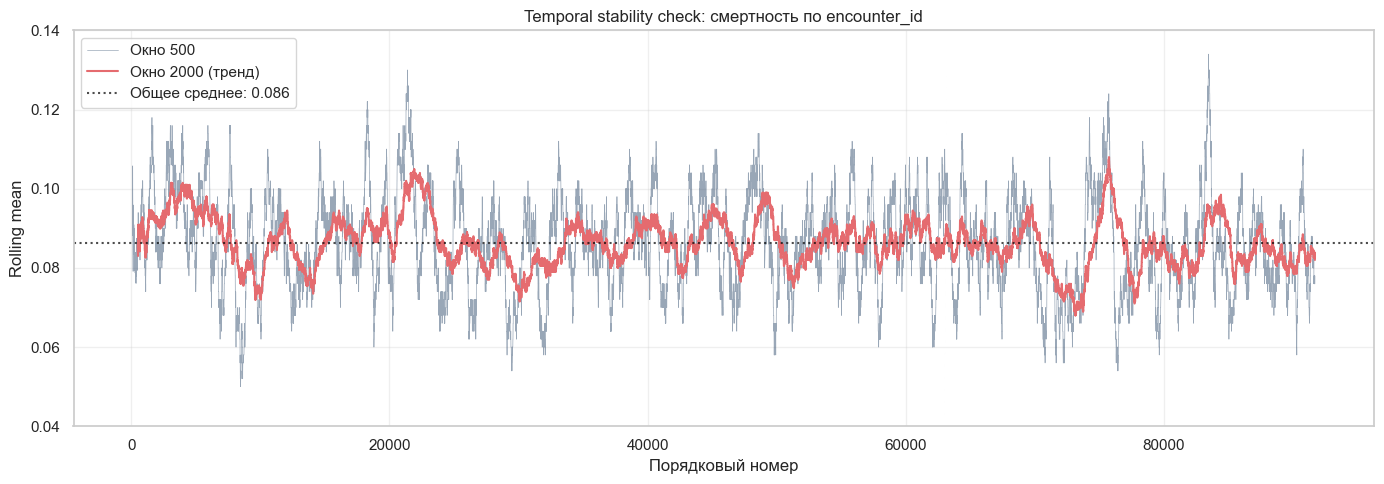

In [7]:
time_col = "encounter_id" if "encounter_id" in train_df.columns else None

if time_col:
    # Сортируем и СБРАСЫВАЕМ индекс
    sorted_df = train_df.sort_values(time_col).reset_index(drop=True)
    overall_mean = train_df[TARGET_COL].mean()  # Общее среднее
    
    fig, ax = plt.subplots(figsize=(14, 5))

    # Скользящие средние с разным окном
    rolling_500 = sorted_df[TARGET_COL].rolling(window=500, min_periods=100).mean()
    rolling_2000 = sorted_df[TARGET_COL].rolling(window=2000, min_periods=500).mean()

    ax.plot(rolling_500, color="#355070", linewidth=0.5, alpha=0.5, label="Окно 500")
    ax.plot(rolling_2000, color="#e56b6f", linewidth=1.5, label="Окно 2000 (тренд)")
    ax.axhline(y=overall_mean, color="black", linestyle=":", alpha=0.7,
               label=f"Общее среднее: {overall_mean:.3f}")

    ax.set_ylim(0.04, 0.14)
    ax.set_title("Temporal stability check: смертность по encounter_id")
    ax.set_ylabel("Rolling mean")
    ax.set_xlabel("Порядковый номер")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Колонка для временного анализа не найдена.")


Таргет стабилен, утечки времени нет

## 3. Анализ признаков

Сформируем группы признаков (числовые, категориальные, потенциально временные), оценим распределения и аномалии.


In [8]:
feature_cols = [c for c in train_df.columns if c not in ID_COLUMNS + [TARGET_COL]]
numeric_features = train_df[feature_cols].select_dtypes(include=["number"]).columns.tolist()
category_features = train_df[feature_cols].select_dtypes(include=["object", "category"]).columns.tolist()
time_like_features = [col for col in feature_cols if any(token in col.lower() for token in ["time", "date", "hour", "minute"])]

print(f"Numeric: {len(numeric_features)}, Categorical: {len(category_features)}, Time-like: {len(time_like_features)}")
pd.Series({"numeric": len(numeric_features), "categorical": len(category_features), "time_like": len(time_like_features)}).to_frame(name="count")


Numeric: 175, Categorical: 8, Time-like: 0


,count
numeric,175
categorical,8
time_like,0


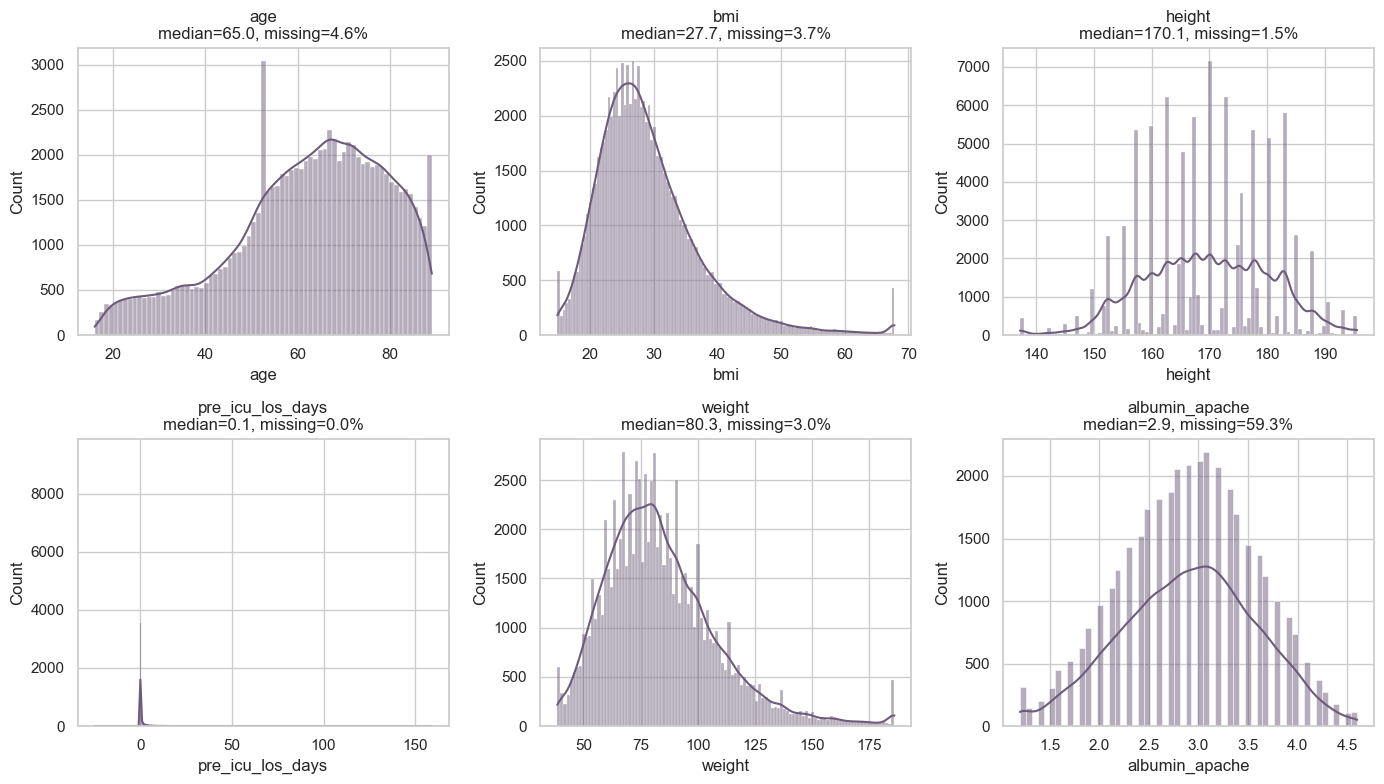

Топ-10 больниц по количеству пациентов:


hospital_id
118    4333
19     3925
188    3095
161    2792
70     2754
196    2730
176    2583
21     2470
194    2258
174    2225
Name: count, dtype: int64

elective_surgery: 18.4% = 1
readmission_status: 0.0% = 1
apache_post_operative: 20.1% = 1
arf_apache: 2.8% = 1


In [9]:
# Разделяем по смыслу, а не по dtype
id_features = ['hospital_id', 'icu_id', 'encounter_id', 'patient_id']
binary_features = ['elective_surgery', 'readmission_status', 'apache_post_operative', 
                   'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache']

true_numeric = [c for c in numeric_features 
                if c not in id_features + binary_features + [TARGET_COL]]

# Для истинно числовых — гистограммы
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for idx, col in enumerate(true_numeric[:6]):
    sns.histplot(train_df[col].dropna(), ax=axes.flat[idx], kde=True, color="#6c5b7b")
    axes.flat[idx].set_title(f"{col}\nmedian={train_df[col].median():.1f}, "
                              f"missing={train_df[col].isna().mean():.1%}")
plt.tight_layout()
plt.show()

# Для ID — value_counts (топ больниц/ICU)
print("Топ-10 больниц по количеству пациентов:")
display(train_df['hospital_id'].value_counts().head(10))

# Для бинарных — простые проценты
for col in binary_features[:4]:
    pct = train_df[col].mean() * 100
    print(f"{col}: {pct:.1f}% = 1")

In [10]:
missing_share = train_df.isna().mean().sort_values(ascending=False).to_frame(name="missing_share")
missing_share.head(20)


,missing_share
h1_bilirubin_min,0.922650
h1_bilirubin_max,0.922650
h1_lactate_max,0.919924
h1_lactate_min,0.919924
h1_albumin_max,0.913982
h1_albumin_min,0.913982
h1_pao2fio2ratio_min,0.874413
h1_pao2fio2ratio_max,0.874413
h1_arterial_ph_max,0.833295
h1_arterial_ph_min,0.833295


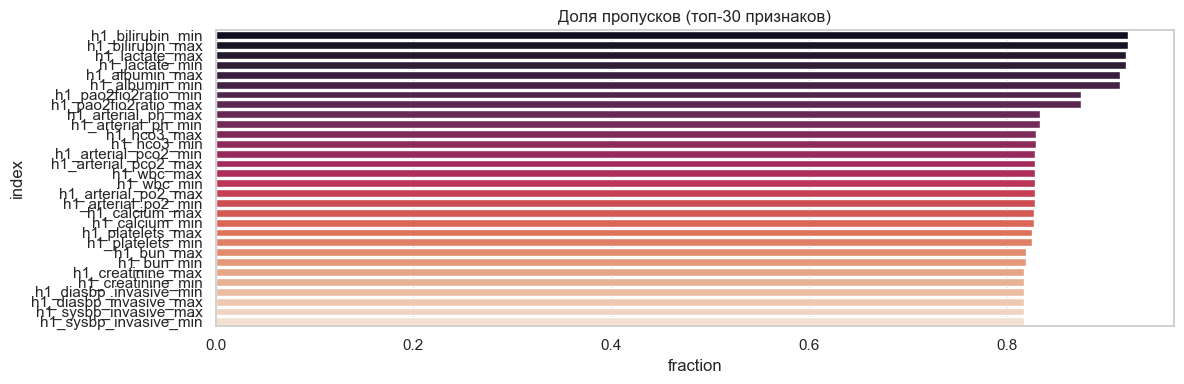

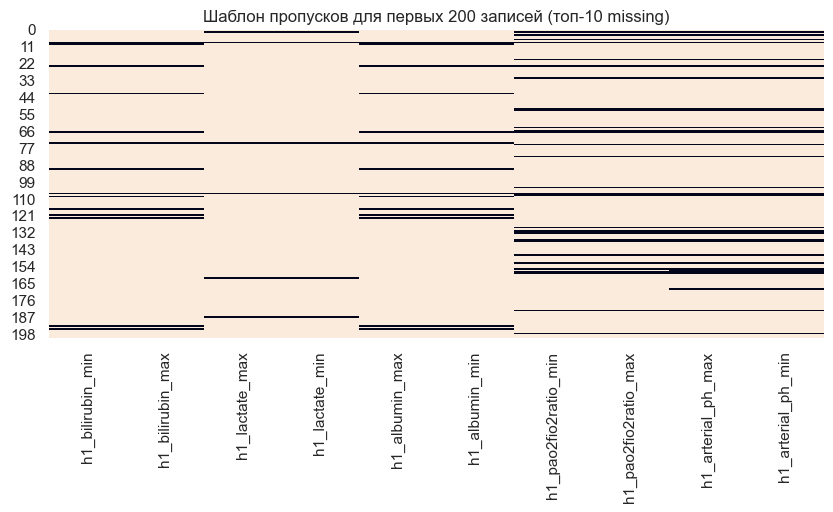

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=missing_share.head(30).reset_index(), x="missing_share", y="index", ax=ax, palette="rocket")
ax.set_title("Доля пропусков (топ-30 признаков)")
ax.set_xlabel("fraction")
plt.tight_layout()
plt.show()

# Heatmap паттернов пропусков (используем топ-10 колонок с наибольшими пропусками)
top_missing_cols = missing_share.head(10).index.tolist()
sample_for_heatmap = train_df[top_missing_cols].isna().astype(int)
plt.figure(figsize=(10, 4))
sns.heatmap(sample_for_heatmap.iloc[:200], cbar=False)
plt.title("Шаблон пропусков для первых 200 записей (топ-10 missing)")
plt.show()


### Ключевой инсайт: Информативность пропусков

Многие лабораторные показатели (albumin, bilirubin, lactate и др.) имеют >50% пропусков. Это не случайность: 
их измеряют преимущественно тяжёлым пациентам. Следовательно, сам факт измерения тоже является предиктором.


In [12]:
# Анализ: связаны ли пропуски с таргетом?
high_missing_cols = missing_share[missing_share['missing_share'] > 0.3].index.tolist()

# Корреляция флагов измеренности с таргетом
missingness_corr = {}
for col in high_missing_cols[:20]:  # топ-20 по пропускам
    flag = train_df[col].notna().astype(int)
    corr = flag.corr(train_df[TARGET_COL])
    missingness_corr[col] = corr

missingness_corr_df = pd.Series(missingness_corr).sort_values(key=abs, ascending=False).to_frame('corr_with_target')
print("Корреляция флагов измеренности с таргетом (топ-20):")
display(missingness_corr_df)

# Вывод: если корреляция значимая, создаём флаги
significant_flags = missingness_corr_df[abs(missingness_corr_df['corr_with_target']) > 0.02].index.tolist()
print(f"\nПризнаков со значимой корреляцией флага: {len(significant_flags)}")
print("→ Рекомендация: создать *_measured флаги для этих признаков в feature engineering")

Корреляция флагов измеренности с таргетом (топ-20):


,corr_with_target
h1_lactate_max,0.098171
h1_lactate_min,0.098171
h1_arterial_pco2_min,0.093103
h1_arterial_pco2_max,0.093103
h1_arterial_po2_max,0.093049
h1_arterial_po2_min,0.093049
h1_arterial_ph_max,0.091421
h1_arterial_ph_min,0.091421
h1_pao2fio2ratio_min,0.079792
h1_pao2fio2ratio_max,0.079792



Признаков со значимой корреляцией флага: 20
→ Рекомендация: создать *_measured флаги для этих признаков в feature engineering


In [13]:
corr_with_target = train_df[numeric_features].corrwith(train_df[TARGET_COL]).dropna().sort_values(key=lambda x: x.abs(), ascending=False)
corr_with_target.head(20).to_frame(name="correlation")


,correlation
d1_lactate_min,0.403614
d1_lactate_max,0.399029
h1_lactate_min,0.344046
h1_lactate_max,0.340951
apache_4a_hospital_death_prob,0.311043
apache_4a_icu_death_prob,0.283913
gcs_motor_apache,-0.282449
gcs_eyes_apache,-0.260373
gcs_verbal_apache,-0.241044
d1_sysbp_invasive_min,-0.234382


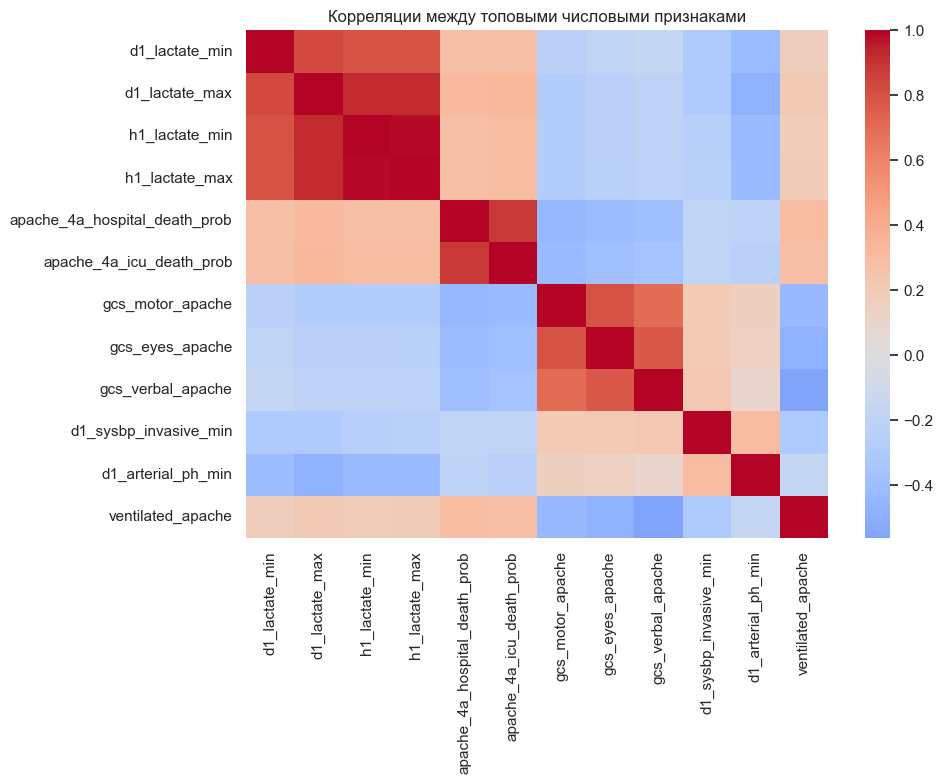

In [14]:
top_corr_features = corr_with_target.head(12).index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_corr_features].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Корреляции между топовыми числовыми признаками")
plt.tight_layout()
plt.show()


In [15]:
top_features_for_model = corr_with_target.head(30).index.tolist()
X = train_df[top_features_for_model]
y = train_df[TARGET_COL]

rf_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(n_estimators=400, max_depth=8, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")),
])

rf_pipeline.fit(X, y)
feature_importance = rf_pipeline.named_steps["model"].feature_importances_
feat_importance_df = pd.Series(feature_importance, index=top_features_for_model).sort_values(ascending=False).to_frame(name="importance")
feat_importance_df.head(20)


,importance
apache_4a_hospital_death_prob,0.250450
apache_4a_icu_death_prob,0.200113
ventilated_apache,0.061174
gcs_motor_apache,0.048969
d1_bun_max,0.047449
d1_lactate_min,0.045701
d1_sysbp_min,0.041299
d1_lactate_max,0.039542
d1_sysbp_noninvasive_min,0.038428
gcs_eyes_apache,0.032869


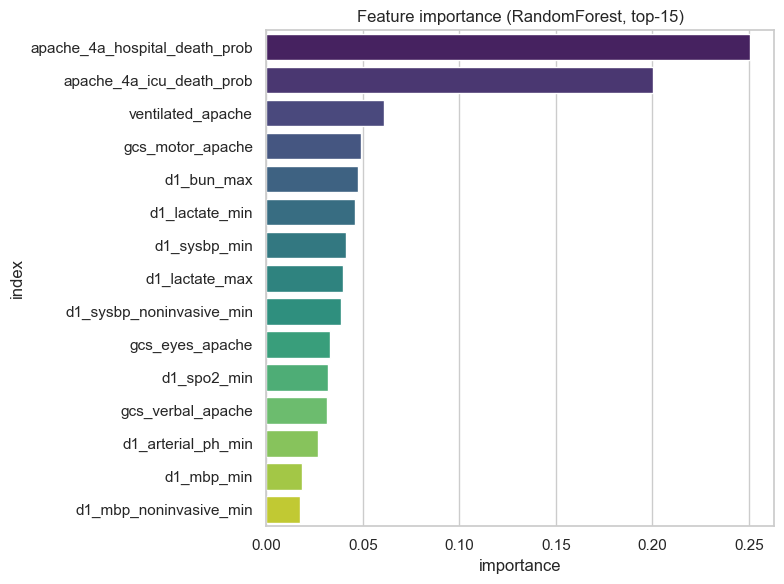

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(data=feat_importance_df.head(15).reset_index(), x="importance", y="index", palette="viridis")
plt.title("Feature importance (RandomForest, top-15)")
plt.tight_layout()
plt.show()

feat_importance_df.to_csv(FIGURES_DIR / "rf_feature_importance.csv")


## 4. Идеи для feature engineering

На основе анализа:

1. **Флаги измеренности**: для показателей с высокой долей пропусков (`albumin_apache`, `bilirubin_apache`, `h1_*` и др.) создать бинарные флаги `*_measured`. 

2. **Log-трансформация скошенных признаков**: `pre_icu_los_days` - медиана 0.1, макс >150, нужно применить `np.log1p()` .

3. **Взаимодействия `apache` и LOS**: признаки `apache_4a_hospital_death_prob`, `apache_4a_icu_death_prob`, `pre_icu_los_days` показывают высокую корреляцию с таргетом - создавать произведения/отношения.

4. **Групповые статистики по ID**: `hospital_id`, `icu_type`, `apache_3j_bodysystem` имеют неоднородность смертности - target encoding.

5. **Категориальные агрегации**: для `icu_admit_source`, `hospital_admit_source` считать долю смертности и частоты.

6. **Feature selection**: по результатам RandomForest отсекать признаки с низкой важностью.
